## Logistic Regression

Logistic Regression is a fundamental supervised learning algorithm used for binary classification problems. Despite its name, it is a classification algorithm, not a regression algorithm. It models the probability that a given input point belongs to a certain class.

Instead of outputting a continuous value like Linear Regression, Logistic Regression uses the **sigmoid (or logistic) function** to map the output of a linear equation to a probability value between 0 and 1.

The equation remains the same as the one for linear regression:

$$y = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_pX_p$$

Then, $y$ is plugged into the Sigmoid function:

$$ P(Y=1 | X) = \sigma(y) = \frac{1}{1 + e^{-y}}$$

The output, $P(Y=1 | X)$, is the estimated probability of the positive class. A threshold (typically 0.5) is then used to make the final classification.

Here is a way to visualize the sigmoid function:

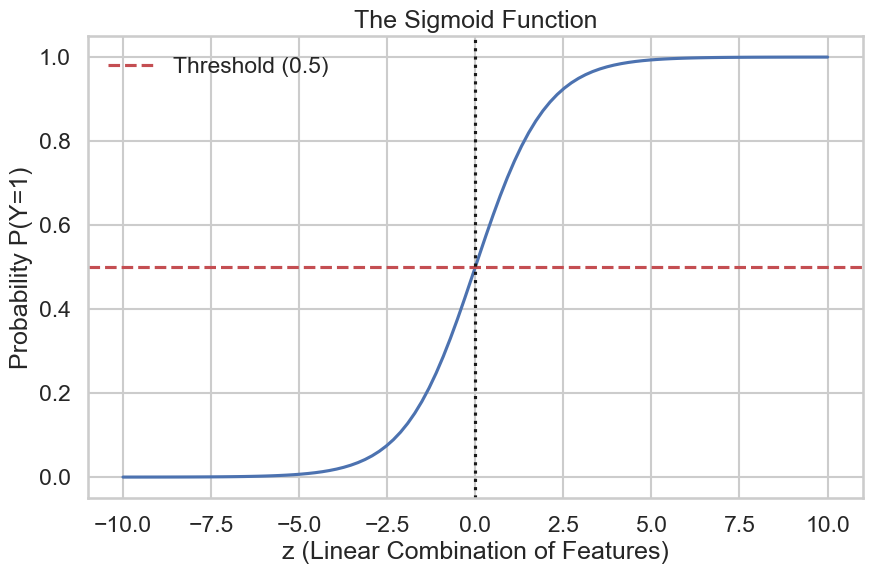

In [31]:
z = np.linspace(-10, 10, 100)
sigma = 1 / (1 + np.exp(-z))

plt.figure(figsize=(10, 6))
plt.plot(z, sigma)
plt.axhline(y=0.5, color='r', linestyle='--', label='Threshold (0.5)')
plt.axvline(x=0, color='k', linestyle=':')
plt.title('The Sigmoid Function')
plt.xlabel('z (Linear Combination of Features)')
plt.ylabel('Probability P(Y=1)')
plt.legend()
plt.grid(True)
plt.show()

We will use Logistic Regression to build a model that classifies whether an NBA player's season was "All-Star caliber." This is the same binary classification task from the Perceptron model, allowing for a direct comparison between a simple linear classifier and a probabilistic one. Given the Perceptron's less than ideal results from the NBA player dataset, we will try again using Logistic Regression, which should produce better results.

## Classifying All-Star Caliber Players

Similarly to the Perceptron model, we will be using the dataset (`all_seasons.csv`). It does not explicitly label All-Stars, meaning we must define it ourselves. We will do this with the following libraries:

1. matplotlib (https://matplotlib.org/)
2. numpy (https://numpy.org/)
3. pandas (https://pandas.pydata.org/)
4. seaborn (https://seaborn.pydata.org/)
5. scikit learn (https://scikit-learn.org/)

We will start by importing the libraries and loading our dataset.

Libraries:

In [32]:
!pip install mlxtend

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

sns.set_theme()
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

And the dataset:

In [33]:
df = pd.read_csv("all_seasons.csv")
df.head()

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97


Now, we will define what it means to have an "all-star caliber" season. We will define it as a season when a player's points per game (`pts`) are within the top 5% of that specific season. This makes sure that the standard for an all-star is kept consistent relative to each unique season.

Create the target variable "all_star_caliber":

In [34]:
all_seasons_results = []
unique_seasons = df['season'].unique()

for season in unique_seasons:
    season_df = df[df['season'] == season].copy()
    pts_percentile_95 = season_df['pts'].quantile(0.95)
    
    season_df['is_all_star'] = (season_df['pts'] >= pts_percentile_95)
    all_seasons_results.append(season_df)

df_with_results = pd.concat(all_seasons_results)

df['all_star_caliber'] = df_with_results['is_all_star'].astype(int)

print("Target variable 'all_star_caliber' created successfully.")
print("\nExample of identified All-Star Caliber players:")
print(df[df['all_star_caliber'] == 1][['season', 'player_name', 'pts', 'all_star_caliber']].head())

Target variable 'all_star_caliber' created successfully.

Example of identified All-Star Caliber players:
     season      player_name   pts  all_star_caliber
7   1996-97        Glen Rice  26.8                 1
8   1996-97   Glenn Robinson  21.1                 1
9   1996-97       Grant Hill  21.4                 1
18  1996-97  Hakeem Olajuwon  23.2                 1
22  1996-97      Gary Payton  21.8                 1


Now we will select the statistics we will use to predict all-star caliber players. Logistic regression more easily allows for more input variables than the Perceptron that we implemented, so we will take advantage of that now. We will use a combination of basic biographical features, as well as basic box score statistics.

In [35]:
features = ['age', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'usg_pct', 'ts_pct']

X = df[features]
y = df['all_star_caliber']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Before we move onto modeling, let's take a quick look at the data we have.

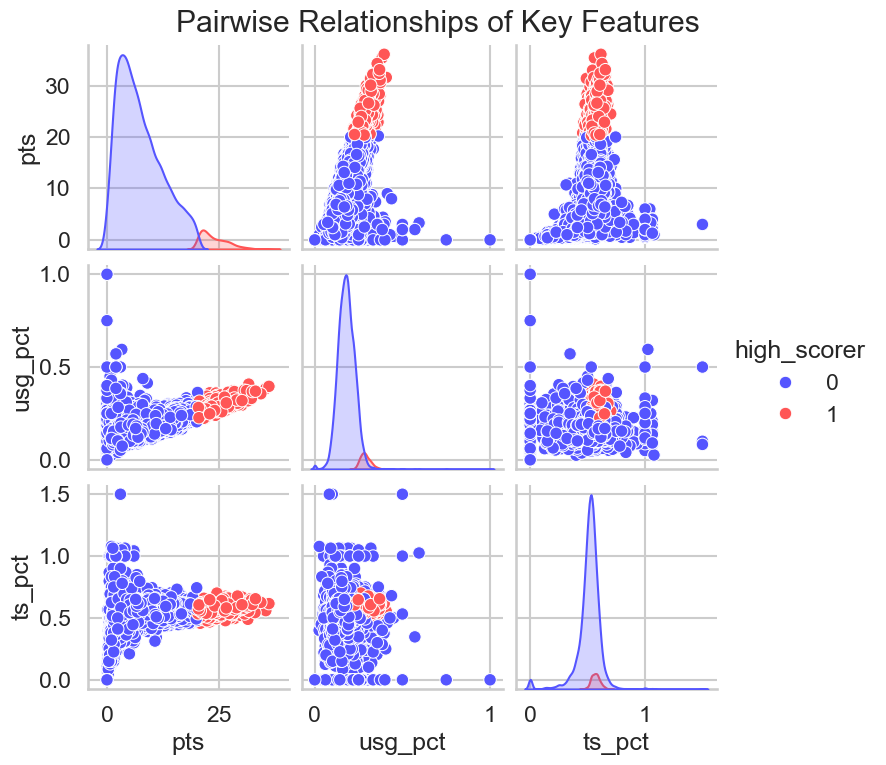

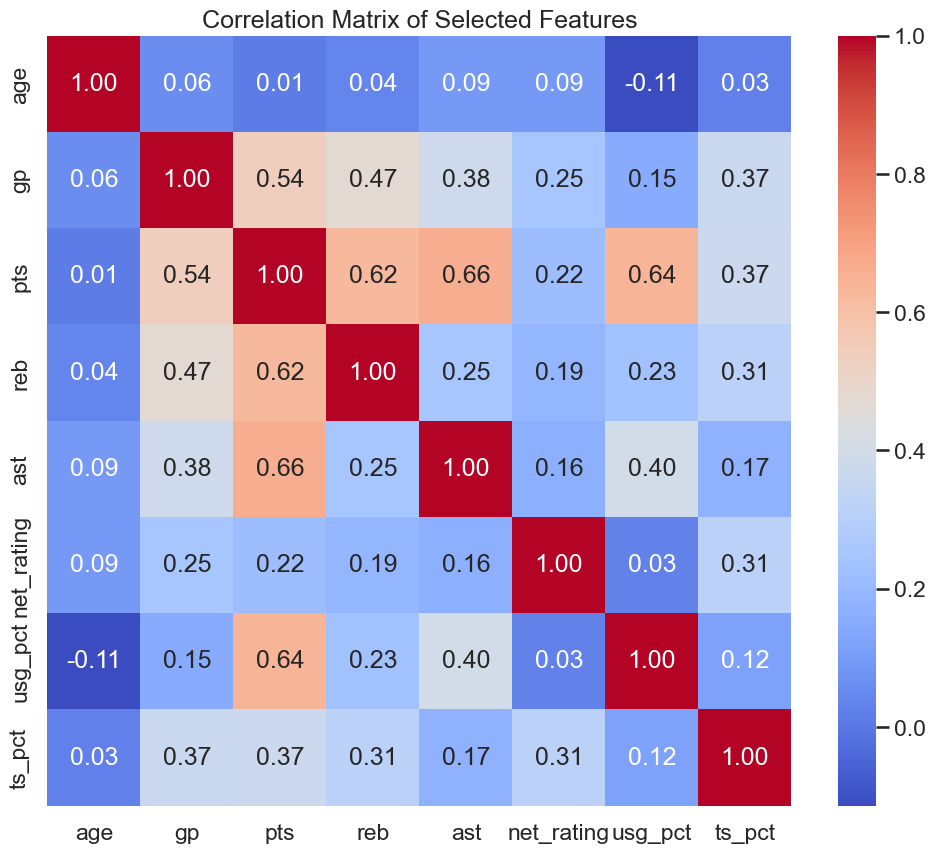

In [36]:
df['high_scorer'] = (df['pts'] >= df['pts'].quantile(0.95)).astype(int)
sns.pairplot(df[['pts', 'usg_pct', 'ts_pct', 'high_scorer']], hue='high_scorer', palette='seismic')
plt.suptitle('Pairwise Relationships of Key Features', y=1.02)
plt.show()

plt.figure(figsize=(12, 10))
corr_cols = ['age', 'gp', 'pts', 'reb', 'ast', 'net_rating', 'usg_pct', 'ts_pct']
corr = df[corr_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Selected Features')
plt.show()

We see that what we have deemed "all-star caliber" players tend to have higher usage rate, which more or less makes intuitive sense. Players who play more will have more opportunity to score more points.

Now that we have selected and standardized our data, we will move onto the modeling part.

### Predictions and Modeling

First, we will initialize, then train (fit) the logistic regression model on our selected, standardized data.

In [37]:
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
print(f"Logistic Regression Model Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print(classification_report(y_test, y_pred, target_names=['Not All-Star Caliber', 'All-Star Caliber']))

Logistic Regression Model Accuracy: 0.9774

                      precision    recall  f1-score   support

Not All-Star Caliber       1.00      0.98      0.99      2437
    All-Star Caliber       0.70      0.99      0.82       132

            accuracy                           0.98      2569
           macro avg       0.85      0.98      0.90      2569
        weighted avg       0.98      0.98      0.98      2569



If we use the sigmoid fucntion to visualize the data and predictions:

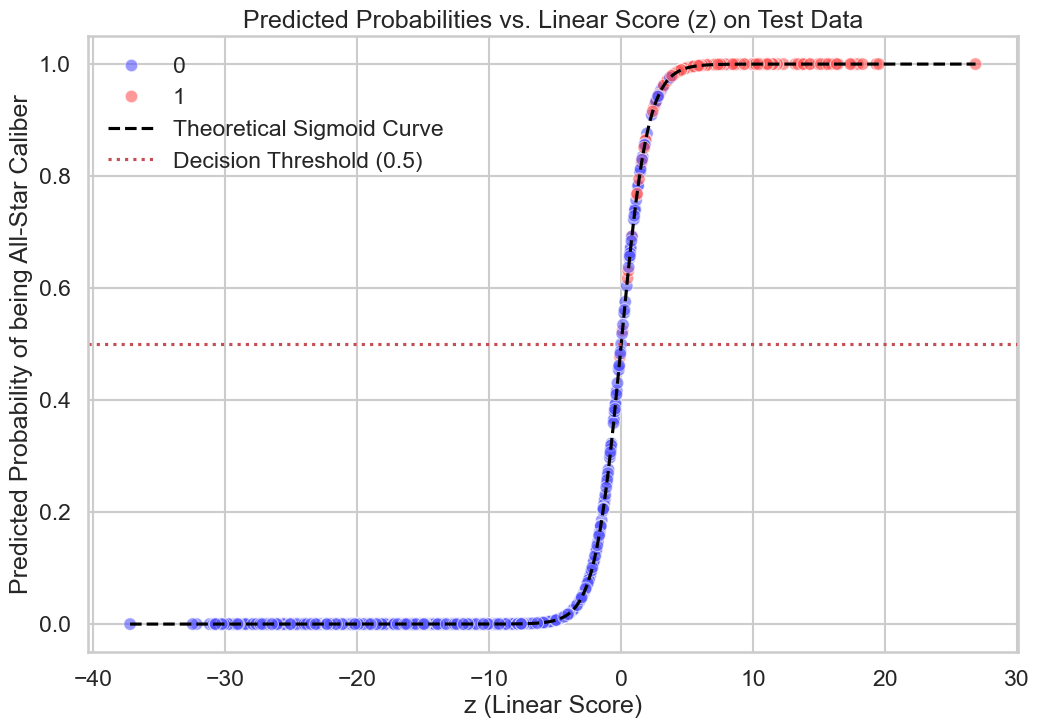

In [38]:
z_test = log_reg.decision_function(X_test_scaled)

prob_test = log_reg.predict_proba(X_test_scaled)[:, 1]

plt.figure(figsize=(12, 8))

sns.scatterplot(x=z_test, y=prob_test, hue=y_test, palette='seismic', alpha=0.6)

z_range = np.linspace(min(z_test), max(z_test), 300)
sigma_range = 1 / (1 + np.exp(-z_range))
plt.plot(z_range, sigma_range, color='black', linestyle='--', label='Theoretical Sigmoid Curve')

plt.axhline(y=0.5, color='r', linestyle=':', label='Decision Threshold (0.5)')
plt.title('Predicted Probabilities vs. Linear Score (z) on Test Data')
plt.xlabel('z (Linear Score)')
plt.ylabel('Predicted Probability of being All-Star Caliber')
plt.legend()
plt.show()

We can observe the much improved accuracy of the Logistic Regression algorithm's ability to predict all-star caliber players, especially compared to that of the Perceptron's.